In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
# =========================
# 1. CARGA DE DATOS
# =========================
df = pd.read_csv("../data/diamantesLimpios.csv")

# One-Hot Encoding para variables categóricas
# drop_first=True evita multicolinealidad
df_encoded = pd.get_dummies(df, drop_first=True)

# Separar variables independientes y target
X = df_encoded.drop("price", axis=1)
y = df_encoded["price"]

# =========================
# 2. TRAIN / TEST SPLIT
# =========================
# Usamos 80/20, más habitual
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ⚠️ IMPORTANTE:
# No usamos StandardScaler porque estos modelos son de árboles
# (no dependen de distancias)

# =========================
# 3. MODELOS BASE
# =========================
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        objective="reg:squarederror",
        random_state=42
    )
}

# =========================
# 4. ENTRENAMIENTO + EVALUACIÓN
# =========================
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"\n-- {name} --")
    print(f"R²:   {r2:.3f}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

print("####################################")

# =========================
# 5. VALIDACIÓN CRUZADA DE RANDOM FOREST (mejor)
# =========================
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# 5-fold Cross Validation con R²
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="r2")

print("\n-- Random Forest CV --")
print(f"R² medio: {cv_scores.mean():.3f}")      # Random Forest: -3.599  posibles outliers
print(f"Desviación: {cv_scores.std():.3f}")

# =========================
# 6. GRID SEARCH (tuning sencillo)
# =========================
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 5, 10]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("\n-- Mejor Random Forest --")
print("Mejores parámetros:", grid.best_params_)
print("R² CV:", grid.best_score_)

# Evaluación final del mejor modelo
best_rf = grid.best_estimator_
preds = best_rf.predict(X_test)

print("\n-- Random Forest Optimizado (Test) --")
print(f"R²:   {r2_score(y_test, preds):.3f}")
print(f"MAE:  {mean_absolute_error(y_test, preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")


-- Decision Tree --
R²:   0.643
MAE:  380.31
RMSE: 5944.63

-- Random Forest --
R²:   0.854
MAE:  323.13
RMSE: 3806.75

-- Gradient Boosting --
R²:   0.868
MAE:  520.72
RMSE: 3615.16

-- XGBoost --
R²:   0.787
MAE:  424.59
RMSE: 4594.60

-- Random Forest CV --
R² medio: -3.382
Desviación: 2.951

-- Mejor Random Forest --
Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 400}
R² CV: 0.788011119721885

-- Random Forest Optimizado (Test) --
R²:   0.828
MAE:  328.80
RMSE: 4126.53


# Importancia de valores


            feature  importance
0             carat    0.722660
27       report_GIA    0.094028
2     shape_Emerald    0.046531
20       clarity_IF    0.022107
12  cut_Super Ideal    0.016920
30     type_natural    0.015862
19          color_J    0.009005
9       shape_Round    0.008479
26     clarity_VVS2    0.007167
24      clarity_VS2    0.006762
29       report_IGI    0.006541
18          color_I    0.006134
22      clarity_SI2    0.005582
25     clarity_VVS1    0.005283
14          color_E    0.004446


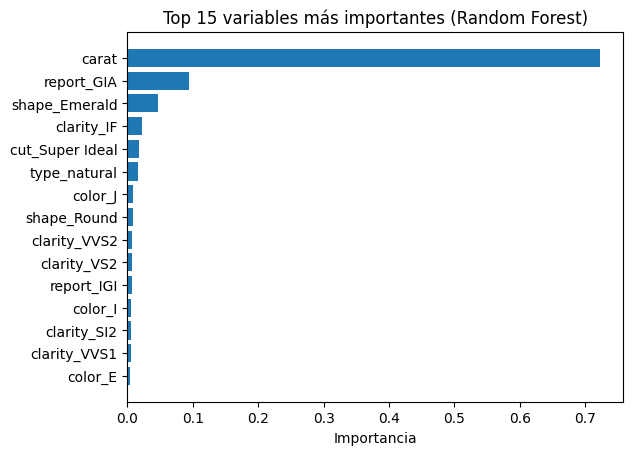

In [11]:
# Usamos el modelo ya entrenado (best_rf si lo tienes)
importances = best_rf.feature_importances_

# Crear DataFrame ordenado
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Ver las 15 más importantes
print(feat_imp.head(15))

# Gráfico
plt.figure()
plt.barh(
    feat_imp.head(15)["feature"][::-1],
    feat_imp.head(15)["importance"][::-1]
)
plt.title("Top 15 variables más importantes (Random Forest)")
plt.xlabel("Importancia")
plt.show()


# Outliers


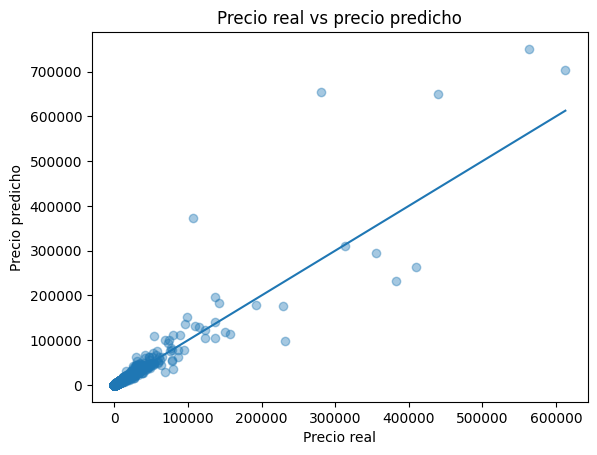

In [13]:
plt.figure()
plt.scatter(y_test, preds, alpha=0.4)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Precio real vs precio predicho")
plt.show()


# Cuanto mas caro el diamante, peor acierta. Va muy bien en precios normales


# Entrenar modelo con Log(price)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Quitamos id y separamos X / y
X = df_encoded.drop(["price"], axis=1)
y = df_encoded["price"]

# 🔑 Transformación logarítmica del precio
y_log = np.log1p(y)

# Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Modelo
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predicciones (en log)
preds_log = rf.predict(X_test)

# Volvemos a precio real
y_test_real = np.expm1(y_test)
preds_real = np.expm1(preds_log)

print("R²:", r2_score(y_test_real, preds_real))
print("MAE:", mean_absolute_error(y_test_real, preds_real))


R²: 0.8455777700489997
MAE: 311.6834564908701


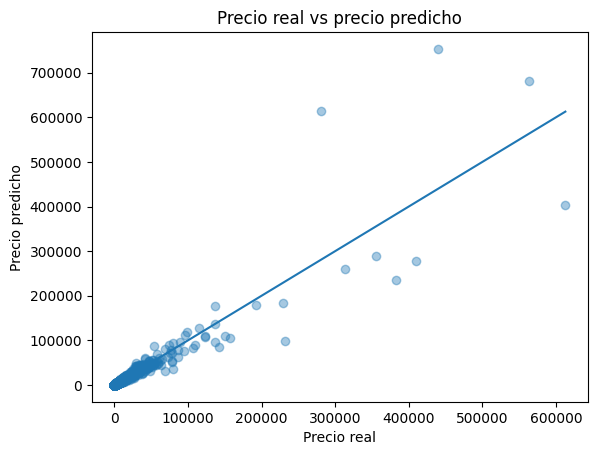

In [16]:
plt.figure()
plt.scatter(y_test_real, preds_real, alpha=0.4)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()]
)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Precio real vs precio predicho")
plt.show()
